In [1]:
from fastai.text import *
import html

# Initialize default model path and input text files path

In [2]:

DATA_PATH=Path('data/')
DATA_PATH.mkdir(exist_ok=True)

#base path containing base models and train / test csv files.
PATH=Path('data/compete/')

#source input files path
CLAS_PATH=Path('data/compete/compete_clas/')
CLAS_PATH.mkdir(exist_ok=True)

#path containing tuned models for specific data.
LM_PATH=Path('data/compete/lm')
LM_PATH.mkdir(exist_ok=True)

#sentence / field tagging.

BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

# Pre process Text data

In [22]:
chunksize=24000
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = list(texts.apply(fixup).values)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

def get_textsFromColumn(df, columnName):
    texts = f'\n{BOS} {FLD} 1 ' + df[columnName].astype(str)
    texts = list(texts.apply(fixup).values)
    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok

# Load and tokenize train / validation data

In [4]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'validation.csv', header=None, chunksize=chunksize)

tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

(LM_PATH/'tmp').mkdir(exist_ok=True)

np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

0
0


# Transform input to word frequency index

In [7]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)
max_vocab = 60000
min_freq = 2

itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')

itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))
vs=len(itos)

# Load the base model

In [8]:
em_sz,nh,nl = 400,1150,3
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

# Tune the base model with train data by freezing all the layers except the last one

In [9]:
wd=1e-7
bptt=70
bs=20
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7


learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

learner.model.load_state_dict(wgts)

lr=1e-3
lrs = lr

learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

learner.save('lm_last_ft')

learner.load('lm_last_ft')

learner.unfreeze()

learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)
learner.save('lm1')
learner.save_encoder('lm1_enc')

epoch      trn_loss   val_loss   accuracy   
    0      5.104661   4.692984   0.328163  



epoch      trn_loss   val_loss   accuracy   
    0      3.358544   3.024257   0.491014  
    1      2.898948   2.711877   0.528458  
    2      2.606219   2.578647   0.546137  
    3      2.399339   2.526175   0.550314  
    4      2.232501   2.516931   0.556467  
    5      2.098649   2.511456   0.559436  
    6      1.969581   2.539518   0.561075  
    7      1.860421   2.585535   0.561073  
    8      1.758834   2.638545   0.560078  
    9      1.685596   2.649763   0.562834  
    10     1.60215    2.680853   0.561061  
    11     1.543638   2.689721   0.56235   
    12     1.494088   2.697934   0.564806  
    13     1.459922   2.7471     0.560623  
    14     1.520683   2.732802   0.563746  



# Transform the train / text with base model word index mapping

In [10]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'validation.csv', header=None, chunksize=chunksize)
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

0
0


# Tune the classifier layer

 79%|███████▊  | 570/725 [00:08<00:02, 65.52it/s, loss=1.52]


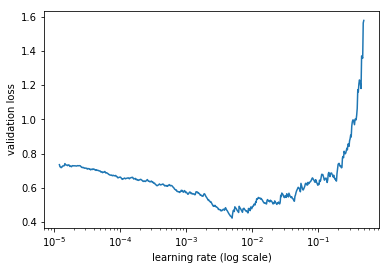

In [11]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 20

min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

# part 1
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5

m = get_rnn_classifier(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.25
learn.metrics = [accuracy]

lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

wd = 1e-7
wd = 0
learn.load_encoder('lm1_enc')

learn.freeze_to(-1)

learn.lr_find(lrs/1000)
learn.sched.plot()

epoch      trn_loss   val_loss   accuracy   
    0      0.440585   0.267219   0.9       



[array([0.26722]), 0.8999999983986812]

In [13]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

learn.save('clas_0')
learn.load('clas_0')

learn.freeze_to(-2)


learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

learn.save('clas_1')

learn.load('clas_1')

learn.fit(lrs, 1, wds=wd, cycle_len=14, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy   
    0      0.471897   0.272359   0.910448  



epoch      trn_loss   val_loss   accuracy   
    0      0.405085   0.281258   0.91194   



epoch      trn_loss   val_loss   accuracy   
    0      0.389568   0.267686   0.913433  
    1      0.455921   0.254279   0.914925  
    2      0.354226   0.283649   0.907463  
    3      0.442801   0.295507   0.901493  
    4      0.263735   0.277003   0.910448  
    5      0.416738   0.314634   0.90597   
    6      0.325689   0.305837   0.904478  
    7      0.315699   0.293831   0.904478  
    8      0.316908   0.57784    0.897015  
    9      0.253121   0.414724   0.901493  
    10     0.254628   0.421932   0.902985  
    11     0.190889   0.42237    0.9       
    12     0.255863   0.397039   0.90597   
    13     0.145409   0.413461   0.90597   



[array([0.41346]), 0.9059701464069423]

In [16]:
def validateTestData(tokens):
    m[0].bs=1
    i = 0
    results = []
    while i < len(tokens):
        m.eval()
        m.reset()
        idxs = np.array([[stoi[p] for p in tokens[i]]])
        idxs = np.transpose(idxs)
        p = m(VV(idxs))
        results.append(torch.topk(p[0],1)[1].data.tolist()[0])
        i+=1
        preds = np.asarray(results)
    return preds

In [18]:
def generateSubmission(df, predictValues, csvFile, idColumn, targetColumn):
    result_df = pd.DataFrame(columns = [idColumn, targetColumn])
    result_df[idColumn] = df[idColumn]
    result_df[targetColumn] = predictValues
    result_df.to_csv(csvFile, index=False)

In [23]:
df_test = pd.read_csv(LM_PATH/'test_submit.csv')
tok_test = get_textsFromColumn(df_test, 'tweet')
pred_value = validateTestData(tok_test)
generateSubmission(df_test, pred_value, 'submission.csv', 'id', 'label')